In [1]:
import sys
from sklearn.neighbors import NearestNeighbors as knn
from sklearn.decomposition import TruncatedSVD
import numpy as np

# X = np.loadtxt('data/mnist2500_X.txt')
# labels = np.loadtxt('data/mnist2500_labels.txt')
X = np.loadtxt('data/mnist2500_X_shift.txt')
labels = np.loadtxt('data/mnist2500_labels_shift.txt')

X -= np.min(X)
X /= np.max(X)
X -= np.mean(X, axis=0)
X = TruncatedSVD(n_components=50, random_state=0).fit_transform(X)

FileNotFoundError: [Errno 2] No such file or directory: 'data/mnist2500_X_shift.txt'

In [4]:
"""
Created on Sat May 27 12:46:25 2017

@author: ehsanamid
"""

def generate_triplets(X, kin=50, kout=10, kr=5, weight_adj=False, random_triplets=True):
    num_extra = np.maximum(kin+50, 60) # look up more neighbors
    # ^ ???
    n = X.shape[0]
    nbrs = knn(n_neighbors= num_extra + 1, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
#    sig = distances[:,10]
    sig = np.maximum(np.mean(distances[:, 10:20], axis=1), 1e-20) # scale parameter
    P = np.exp(-distances**2/np.reshape(sig[indices.flatten()],[n, num_extra + 1])/sig[:, np.newaxis])
    sort_indices = np.argsort(-P, axis = 1) # actual neighbors
    
    triplets = np.zeros([n * kin * kout, 3], dtype=np.int32)
    weights = np.zeros(n * kin * kout)
    
    cnt = 0
    for i in range(n):
        for j in range(kin):
            sim = indices[i,sort_indices[i, j+1]]
            p_sim = P[i,sort_indices[i, j+1]]
            rem = indices[i,sort_indices[i, :j+2]].tolist()
            l = 0
            while (l < kout):
                out = np.random.choice(n)
                if out not in rem:
                    triplets[cnt] = [i, sim, out]
                    p_out = max(np.exp(-np.sum((X[i] - X[out])**2) / (sig[i] * sig[out])), 1e-20)
                    weights[cnt] = p_sim / p_out
                    rem.append(out)
                    l += 1
                    cnt += 1
        if (i+1) % 500 == 0:
            print('Generated triplets %d / %d' % (i+1, n))
    if random_triplets:
#         kr = 5
        triplets_rand = np.zeros([n * kr, 3])
        weights_rand = np.zeros(n * kr)
        for i in range(n):
            cnt = 0
            while cnt < kr:
                sim = np.random.choice(n)
                out = np.random.choice(n)
                if sim == i or out == i or out == sim:
                    continue
                p_sim = max(np.exp(-np.sum((X[i]-X[sim])**2)/(sig[i] * sig[sim])), 1e-20)
                p_out = max(np.exp(-np.sum((X[i]-X[out])**2)/(sig[i] * sig[out])), 1e-20)
                if p_sim < p_out:
                    sim, out = out, sim
                    p_sim, p_out = p_out, p_sim
                triplets_rand[i * kr + cnt] = [i, sim, out]
                weights_rand[i * kr + cnt] = p_sim / p_out
                cnt += 1
            if (i+1) % 500 == 0:
                print('Generated random triplets %d / %d' % (i+1, n))
        triplets = np.vstack((triplets, triplets_rand))
        weights = np.hstack((weights, weights_rand))
    triplets = triplets[~np.isnan(weights)]
    weights = weights[~np.isnan(weights)]
    weights /= np.max(weights)
    weights += 0.0001
    if weight_adj:
        weights = np.log(1 + 50 * weights)
        weights /= np.max(weights)
    return triplets, weights

In [5]:
triplets, weights = generate_triplets(X)

Generated triplets 500 / 5000
Generated triplets 1000 / 5000
Generated triplets 1500 / 5000
Generated triplets 2000 / 5000
Generated triplets 2500 / 5000
Generated triplets 3000 / 5000
Generated triplets 3500 / 5000
Generated triplets 4000 / 5000
Generated triplets 4500 / 5000
Generated triplets 5000 / 5000
Generated random triplets 500 / 5000
Generated random triplets 1000 / 5000
Generated random triplets 1500 / 5000
Generated random triplets 2000 / 5000
Generated random triplets 2500 / 5000
Generated random triplets 3000 / 5000
Generated random triplets 3500 / 5000
Generated random triplets 4000 / 5000
Generated random triplets 4500 / 5000
Generated random triplets 5000 / 5000


In [6]:
import torch
from torch import nn, optim
from torch.autograd import Variable

class TriMap(nn.Module):
    
    def __init__(self, triplets, weights, out_shape):
        super(TriMap, self).__init__()
        n, num_dims = out_shape
        self.Y = nn.Embedding(n, num_dims, sparse=False)
        for W in self.Y.parameters():
            W.data = torch.Tensor(np.random.normal(size=[n, num_dims]) * 0.0001)
        self.triplets = Variable(torch.cuda.LongTensor(triplets))
        self.weights = Variable(torch.cuda.FloatTensor(weights))
    
    def forward(self):
        y_ij = self.Y(self.triplets[:, 0]) - self.Y(self.triplets[:, 1])
        y_ik = self.Y(self.triplets[:, 0]) - self.Y(self.triplets[:, 2])
        d_ij = 1 + torch.sum(y_ij**2, -1)
        d_ik = 1 + torch.sum(y_ik**2, -1)
        num_viol = torch.sum((d_ij > d_ik).type(torch.FloatTensor))
        loss = self.weights.dot(d_ij / (d_ij + d_ik))
        return loss, num_viol
    
    def get_embeddings(self):
        return self.Y._parameters['weight'].cpu().data.numpy()

In [96]:
from torch.optim.optimizer import Optimizer, required

i = 0

class SEG(Optimizer):
    
    def __init__(self, params, lr=required):
        defaults = dict(lr=lr)
        super(SEG, self).__init__(params, defaults)
    
    def __setstate__(self, state):
        super(SEG, self).__setstate__(state)
    
    def step(self, closure=None):
        
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                s_p = torch.exp(-group['lr'] * d_p)
                global i
                if i % 100 == 0:
                    print(s_p.mean(), s_p.std())
#                     p.data *= s_p
                i += 1
                
#                 p.data -= group['lr'] * d_p
                p.data *= s_p

In [7]:
num_examples = X.shape[0]
num_triplets = triplets.shape[0]
model = TriMap(triplets, weights, out_shape=[num_examples, 2])
model.cuda()

tol = 1e-7
C = np.inf

eta = 1000.0 / num_triplets * num_examples
# eta = 1000 / num_triplets * num_examples
optimizer = optim.SGD(model.parameters(), lr=eta)
# optimizer = SEG(model.parameters(), lr=eta)

num_iters = 2000

for i in range(num_iters):
    old_C = C
    
    loss, num_viol = model()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    C = loss.data.cpu().numpy()
    viol = float(num_viol) / num_triplets
    
    if old_C > C + tol:
        eta = eta * 1.01
    else:
        eta = eta * 0.5
    optimizer.param_groups[0]['lr'] = eta
    
    if (i+1) % 100 == 0:
#         print(eta)
        print('Iteration: %4d, Loss: %3.3f, Violated triplets: %0.4f' % (i+1, loss, viol))

Y = model.get_embeddings()

2.6515183113631307
Iteration:  100, Loss: 112.966, Violated triplets: 0.1182
7.171863397539409
Iteration:  200, Loss: 42.242, Violated triplets: 0.0350
19.398555300386665
Iteration:  300, Loss: 28.597, Violated triplets: 0.0338
52.469480647284136
Iteration:  400, Loss: 23.051, Violated triplets: 0.0337
141.92017687733934
Iteration:  500, Loss: 19.631, Violated triplets: 0.0326
383.8676570917767
Iteration:  600, Loss: 17.093, Violated triplets: 0.0302
514.0052215690488
Iteration:  700, Loss: 15.820, Violated triplets: 0.0296
688.2615998489308
Iteration:  800, Loss: 15.131, Violated triplets: 0.0294
456.23455875188057
Iteration:  900, Loss: 14.828, Violated triplets: 0.0294
610.9057148376812
Iteration: 1000, Loss: 14.479, Violated triplets: 0.0294
818.0129831512897
Iteration: 1100, Loss: 14.224, Violated triplets: 0.0294
542.2441009396059
Iteration: 1200, Loss: 14.025, Violated triplets: 0.0294
726.0739322493511
Iteration: 1300, Loss: 13.868, Violated triplets: 0.0293
972.2251550151059
I

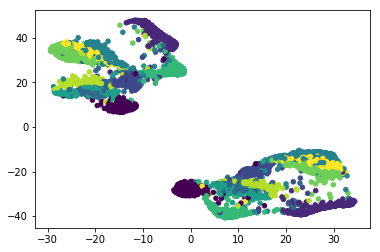

In [8]:
import matplotlib.pyplot as plt

plt.scatter(Y[:, 0], Y[:, 1], 20, labels)
plt.show()